## CS 372

### Assignment 1 - KNN, Naive Bayes, Python, and You!

- Grace Biggs

- Brandon L'Abbe

- Lane Thompson

- Zhiyi Zhan

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             5.993117          2.500989           4.542148          1.348742   
1             5.657568          3.714626           1.800290          0.531637   
2             7.751423          2.662903           7.174372          2.335111   
3             5.938142          3.034625           4.448674          1.426435   
4             7.054747          2.741609           4.268965          1.469104   
..                 ...               ...                ...               ...   
147           5.857968          3.949036           1.170024          0.305553   
148           5.966645          2.334692           3.927622          1.186082   
149           7.197063          2.845467           5.882156          2.105997   
150          10.000000          3.500000           8.000000          2.000000   
151           4.500000          2.000000           1.500000          0.200000   

        species  
0    vers

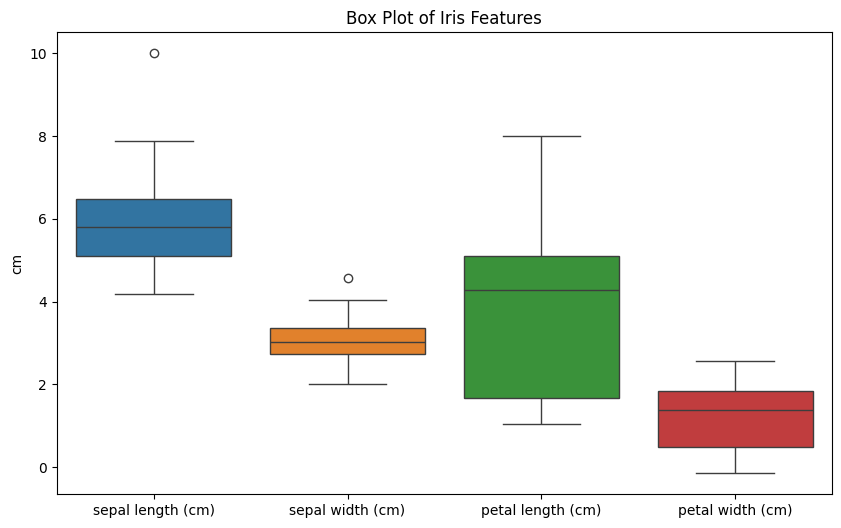

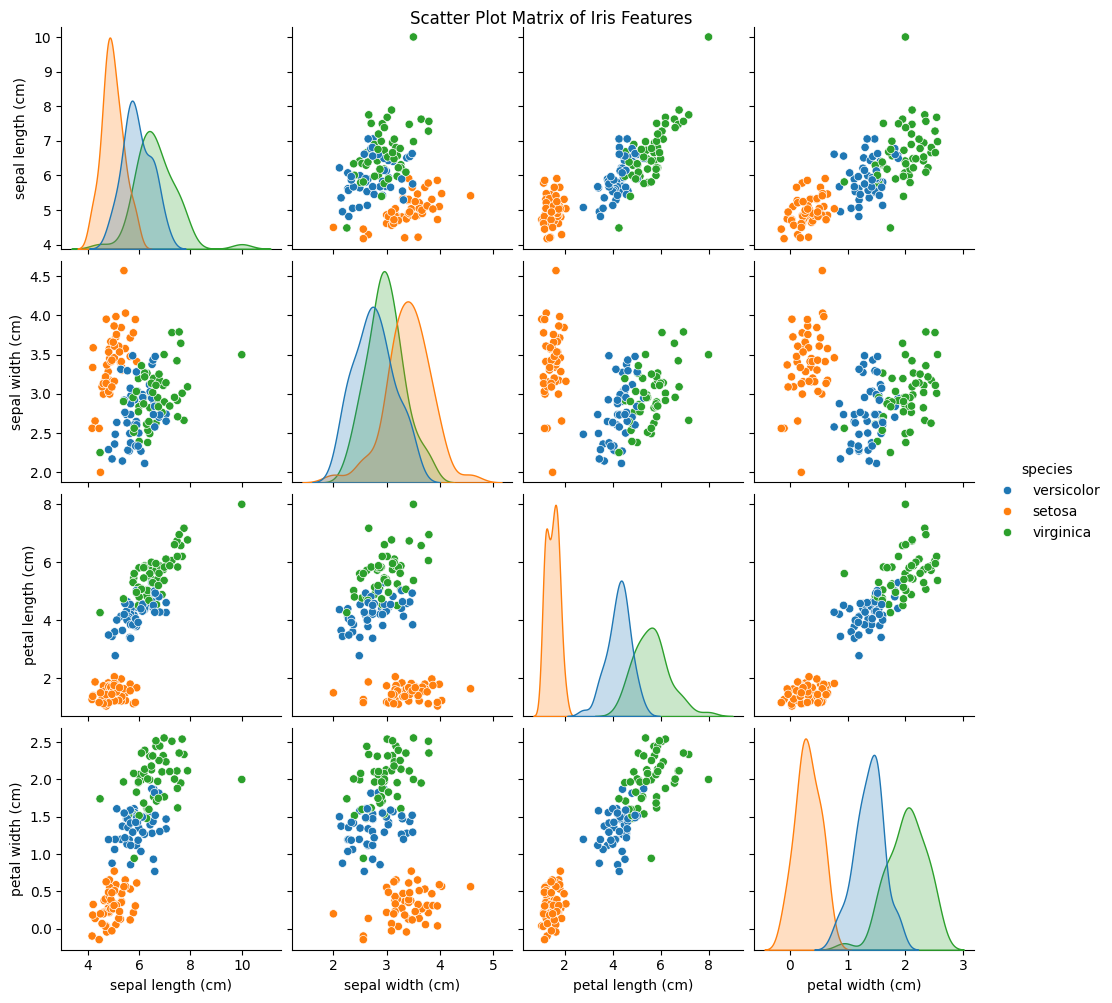

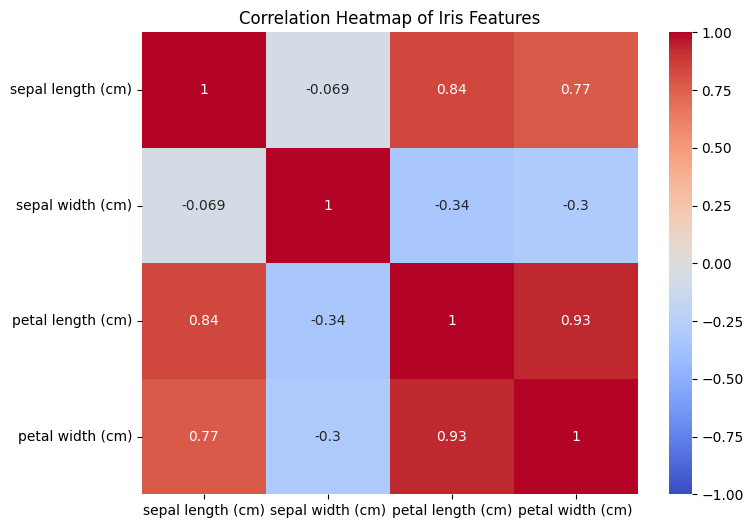

In [42]:
# Question 1. 
# Exploratory Data Analysis For Iris Dataset
## 1. Check for missing data and duplicates.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('iris.csv')
print(df)

print("Duplicate rows: ")
print(df.duplicated().sum()) # no duplicates

print("Missing values: ")
print(df.isnull().sum()) # 8 values missing from the sepal width column

# Fill missing values with median
df['sepal width (cm)'] = df.groupby('species')['sepal width (cm)'].transform(
    lambda x: x.fillna(x.median())
)

## 2. Draw a Box Plot to spot outliers.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.drop(columns='species'))
plt.title('Box Plot of Iris Features')
plt.ylabel('cm')
plt.show()

## 3. Draw a Scatter Plot Matrix for Iris flowers' descriptive features.
sns.pairplot(df, hue='species', diag_kind='kde')
plt.suptitle('Scatter Plot Matrix of Iris Features', y=1.0)
plt.show()

## 4. Plot Heatmap correlation for descriptive features.
plt.figure(figsize=(8,6))
corr = df.drop(columns='species').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Iris Features')
plt.show()


In [43]:
# Split the data 80/20.
## 1. Preserve the proportion of each class when splitting. 
## 2. Shuffle data before split. Also make sure this code block reruns and randomizes the split correctly.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X = df.drop(columns='species')
y = df['species']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    shuffle=True,
    random_state=42
)

Metric Comparison:
Euclidean - Train: 0.9256, Test: 0.9032
Manhattan - Train: 0.9339, Test: 0.8710


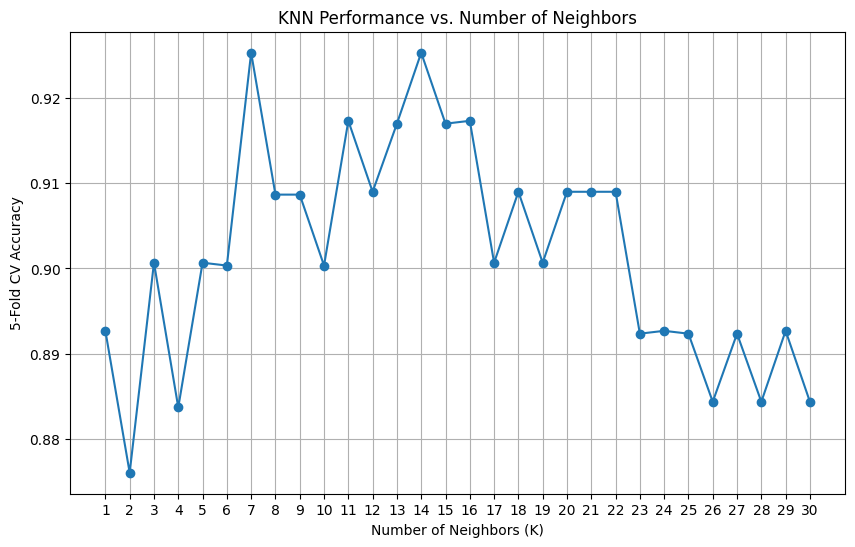

Best K: 7 with accuracy: 0.9253

Test Accuracy (k=7): 0.9032

Misclassified Flowers:
    true_species predicted_species
110   versicolor         virginica
111    virginica        versicolor
84    versicolor         virginica


In [44]:
# KNN
## 3. Use StandardScaler to put all descriptive features on the same scale.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.neighbors import KNeighborsClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn.model_selection import cross_val_score # https://scikit-learn.org/stable/modules/cross_validation.html

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Implement KNN using SKLearn's KNeighborsClassifier.
## 5. Experiment with different distance metrics (Euclidean and Manhattan). Compare the two and comment on your findings.
metrics = ['euclidean', 'manhattan']
results = {}

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
    knn.fit(X_train_scaled, y_train)
    train_acc = knn.score(X_train_scaled, y_train)
    test_acc = knn.score(X_test_scaled, y_test)
    results[metric] = {'train': train_acc, 'test': test_acc}

print("Metric Comparison:")
for metric, scores in results.items():
    print(f"{metric.capitalize()} - Train: {scores['train']:.4f}, Test: {scores['test']:.4f}")
# Euclidean performs 3% better than Manhattan on the Test dataset, and only marginally worse than Manhattan on the training set.
# Both are comparable to each other but it's safe to say that Euclidean provides better accuracy.

## 6. Choose the best number of neighbors using 5-fold cross validation.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
k_values = np.arange(1, 31) # Realistically overkill but this makes for a nice graph
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

## 7. Draw a 2D plot to show the average accuracy of KNN classifier vs. different values of K. Analyze the result and comment on the plot.
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-')
plt.title('KNN Performance vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('5-Fold CV Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(cv_scores)]
print(f"Best K: {best_k} with accuracy: {max(cv_scores):.4f}")

## 8. Evaluate your model on the test data using Accuracy based on the best K found above. 
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
best_knn.fit(X_train_scaled, y_train)
test_accuracy = best_knn.score(X_test_scaled, y_test)
print(f"\nTest Accuracy (k={best_k}): {test_accuracy:.4f}")

## Show misclassified flowers in a table, with the true label in one column and the predicted table in another column. Comment on results.
y_pred = best_knn.predict(X_test_scaled)
misclassified = X_test.copy()
misclassified['true_species'] = y_test
misclassified['predicted_species'] = y_pred
misclassified = misclassified[y_test != y_pred]

print("\nMisclassified Flowers:")
print(misclassified[['true_species', 'predicted_species']])
# Three flowers misclassified 

In [45]:
# Naive Bayes
## 1. Use the built-in SKLearn library to predict the species of Iris in the test dataset.
from sklearn.naive_bayes import GaussianNB # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.metrics import accuracy_score # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled, y_train)
y_pred_nb = nb_classifier.predict(X_test_scaled)

## 2. Use Accuracy to assess the performance of your classifier.
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"\nNaive Bayes Test Accuracy: {nb_accuracy:.4f}")

## 3. Show misclassified flowers in a table, with the true label in one column and the predicted table in another column. Comment on it.
misclassified_nb = X_test.copy()
misclassified_nb['true_species'] = y_test
misclassified_nb['predicted_species'] = y_pred_nb
misclassified_nb = misclassified_nb[y_test != y_pred_nb]
print("\nMisclassified Flowers (Naive Bayes):")
print(misclassified_nb[['true_species', 'predicted_species']])
# Accuracy and misclassifications are exactly the same as KNN... 


Naive Bayes Test Accuracy: 0.9032

Misclassified Flowers (Naive Bayes):
    true_species predicted_species
110   versicolor         virginica
111    virginica        versicolor
84    versicolor         virginica


     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

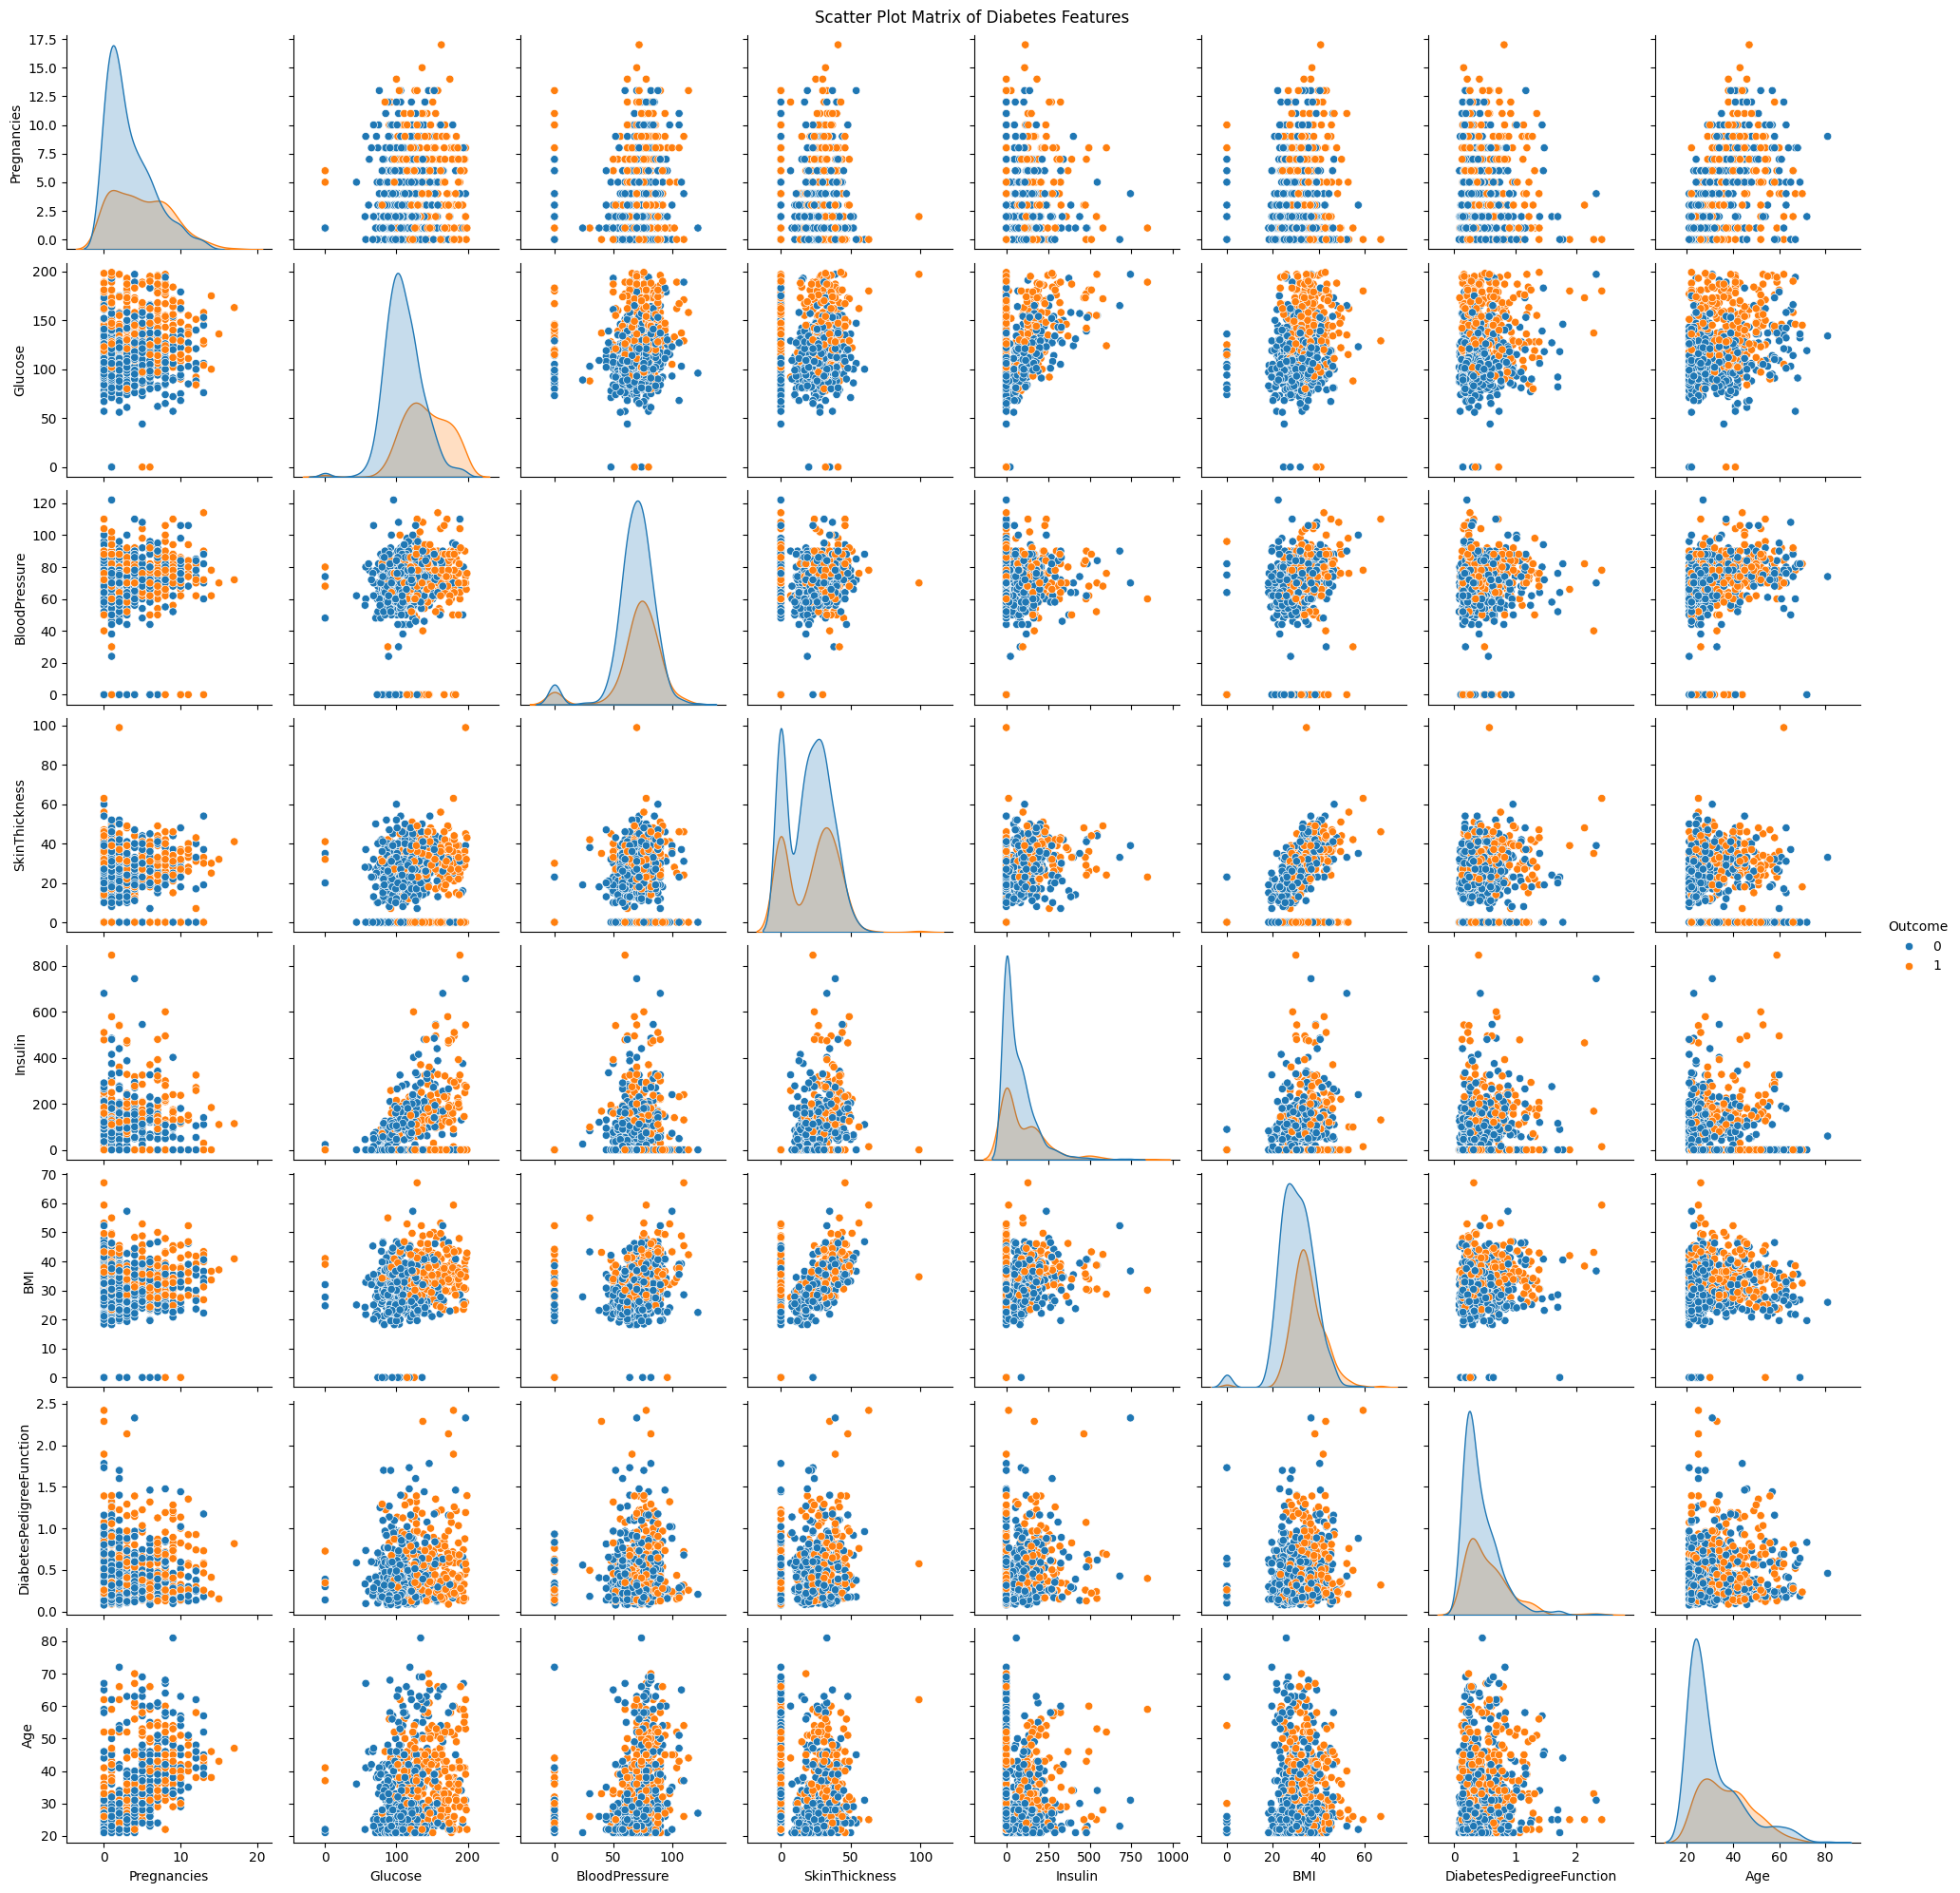

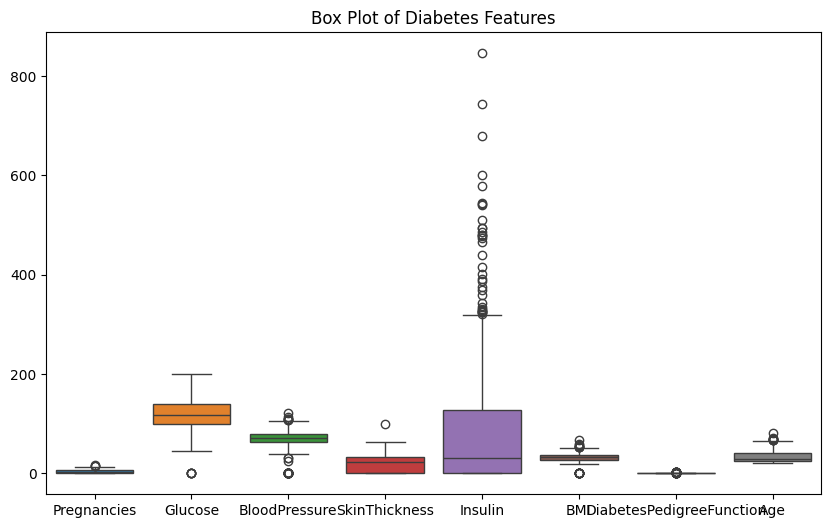

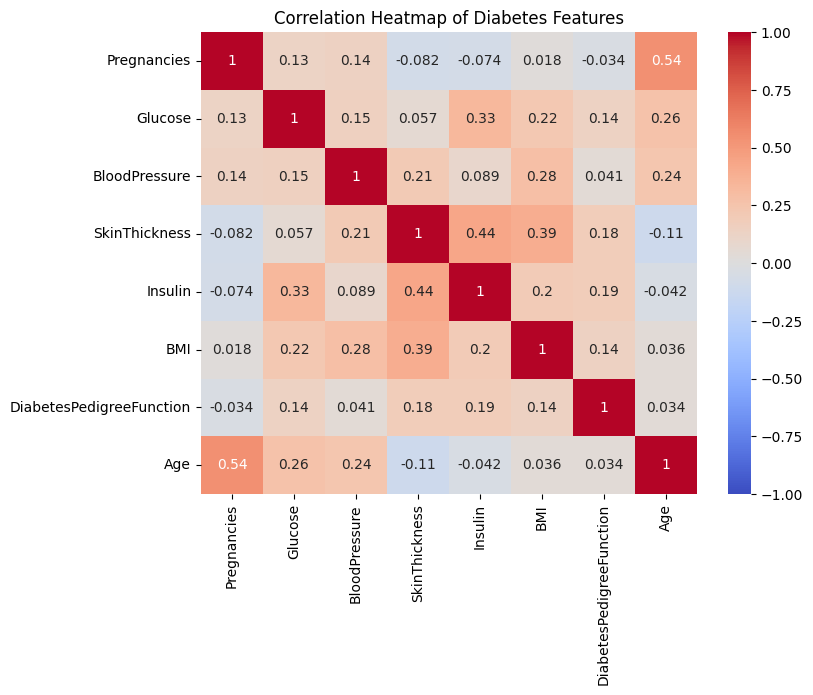

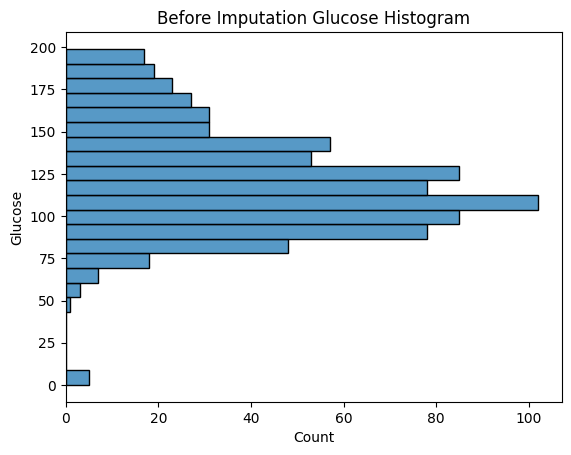

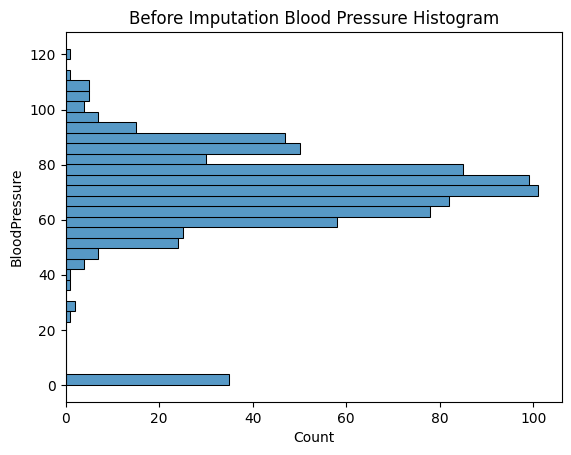

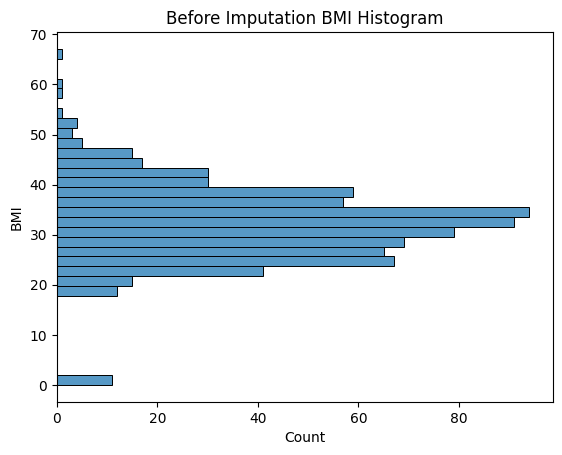

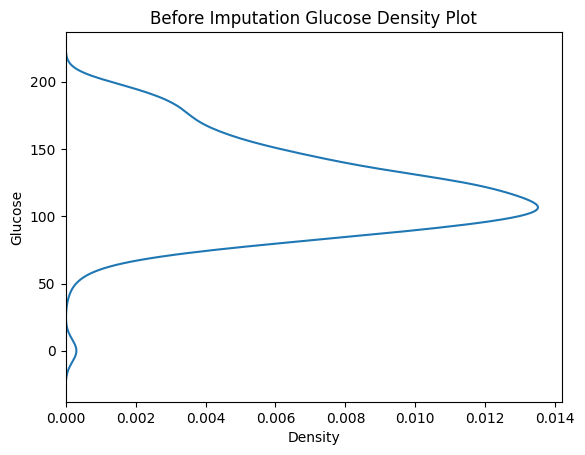

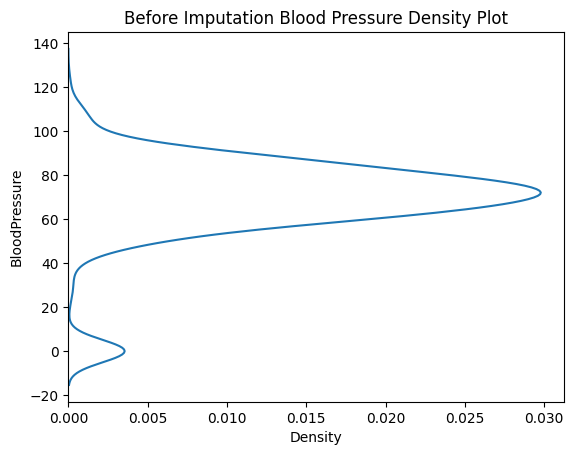

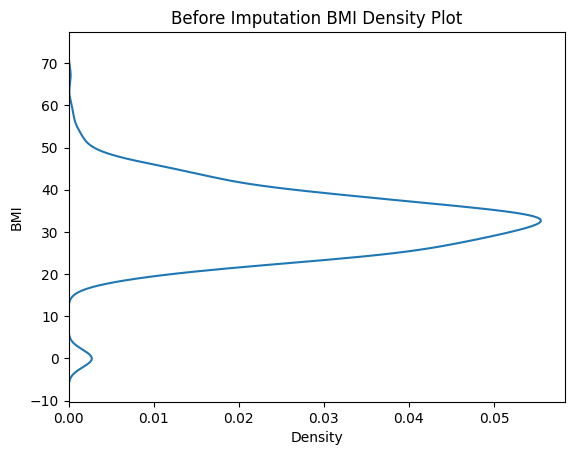

Invalid values: 
44


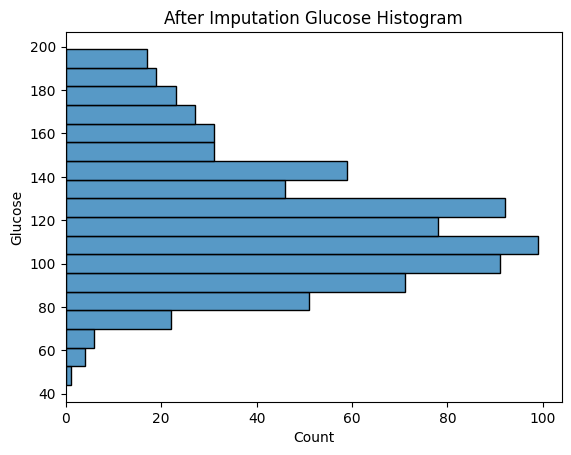

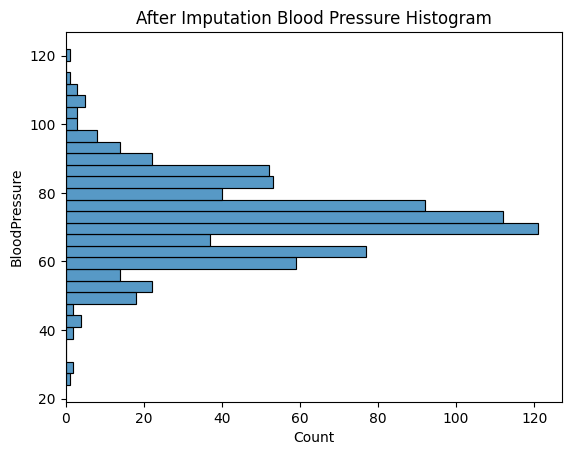

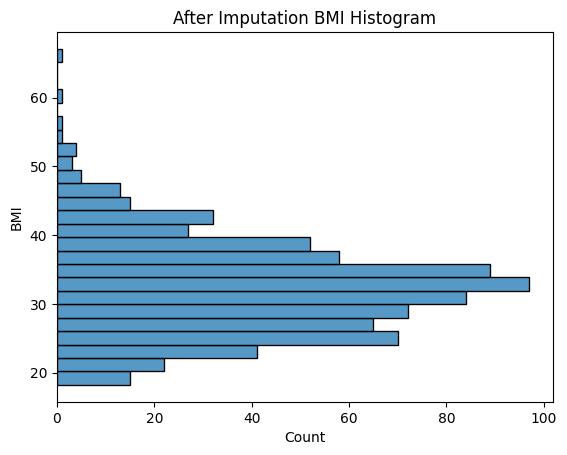

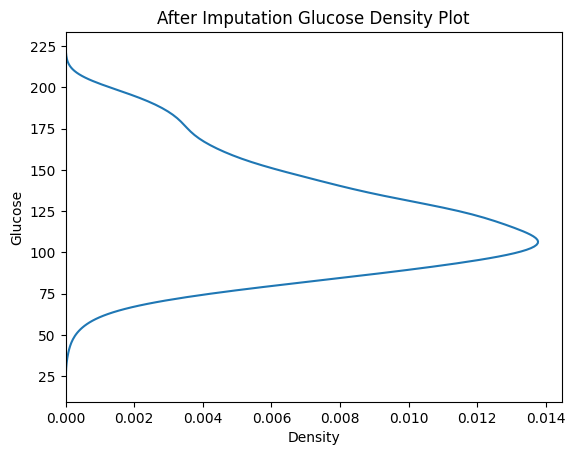

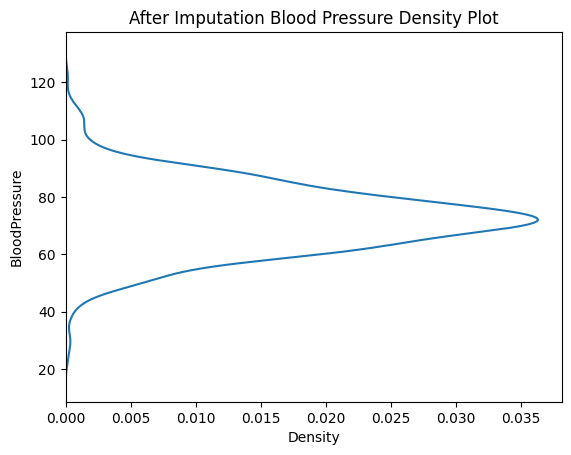

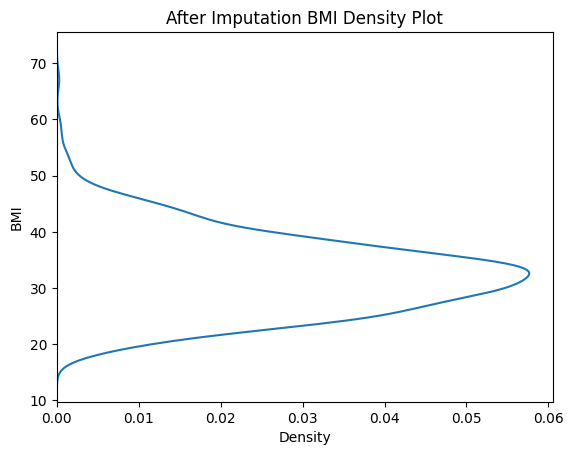

In [2]:
# Question 2. Predicting the onset of diabetes based on diagnostic measures.
# Exploratory Data Analysis of Pima Indians Diabetes Database.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Check for missing data and duplicates.
df = pd.read_csv('diabetes.csv')
print(df)

print("Duplicate rows: ")
print(df.duplicated().sum()) # no duplicates

# For this dataset, there are no empty values, but there are some columns with an invalid value of 0
# We will deal with this in Step 5 where we are suppose to identify unrealistic values
print("Missing values: ")
print(df.isnull().sum())

## 2. Draw a Scatter Plot Matrix
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.suptitle('Scatter Plot Matrix of Diabetes Features', y=1.0)
plt.show()

## 3. Draw a Box Plot to spot outliers.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.drop(columns='Outcome'))
plt.title('Box Plot of Diabetes Features')
plt.show()

# TODO: Document decisions on how to handle outliers based on your analysis and reasoning.

## 4. Plot Heatmap correlation for descriptive features.
plt.figure(figsize=(8,6))
corr = df.drop(columns='Outcome').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Diabetes Features')
plt.show()

## 5. Identify features containing unrealistic zero values
# We want to check Glucose, Blood Pressure, and BMI for zeroes, all other columns can have 0 values
# To deal with this, we should treat them the same as missing values, replacing the 0s with the median value

sns.histplot(df, y='Glucose')
plt.title('Before Imputation Glucose Histogram')
plt.show()

sns.histplot(df, y='BloodPressure')
plt.title('Before Imputation Blood Pressure Histogram')
plt.show()

sns.histplot(df, y='BMI')
plt.title('Before Imputation BMI Histogram')
plt.show()

sns.kdeplot(df, y='Glucose')
plt.title('Before Imputation Glucose Density Plot')
plt.show()

sns.kdeplot(df, y='BloodPressure')
plt.title('Before Imputation Blood Pressure Density Plot')
plt.show()

sns.kdeplot(df, y='BMI')
plt.title('Before Imputation BMI Density Plot')
plt.show()

print("Invalid values: ")
missing_value_rows = df.query('Glucose == 0 or BloodPressure == 0 or BMI == 0')
print(missing_value_rows.count()['BMI']) # Arbitraility polling the count for the BMI column (they are all the same on count)

#Replace invalid values with median
df['Glucose'] = df.groupby('Outcome')['Glucose'].transform(
    lambda x: x.replace(0, x.median())
)

df['BloodPressure'] = df.groupby('Outcome')['BloodPressure'].transform(
    lambda x: x.replace(0, x.median())
)

df['BMI'] = df.groupby('Outcome')['BMI'].transform(
    lambda x: x.replace(0, x.median())
)

#Post Imputation Plots... These show the 0 groups disappearing
sns.histplot(df, y='Glucose')
plt.title('After Imputation Glucose Histogram')
plt.show()

sns.histplot(df, y='BloodPressure')
plt.title('After Imputation Blood Pressure Histogram')
plt.show()

sns.histplot(df, y='BMI')
plt.title('After Imputation BMI Histogram')
plt.show()

sns.kdeplot(df, y='Glucose')
plt.title('After Imputation Glucose Density Plot')
plt.show()

sns.kdeplot(df, y='BloodPressure')
plt.title('After Imputation Blood Pressure Density Plot')
plt.show()

sns.kdeplot(df, y='BMI')
plt.title('After Imputation BMI Density Plot')
plt.show()


# Split the data 80/20.
## 1. Preserve the proportion of each class when splitting. 
## 2. Shuffle data before split. Also make sure this code block reruns and randomizes the split correctly.
import numpy as np
from sklearn.model_selection import train_test_split # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X = df.drop(columns='Outcome')
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    shuffle=True,
    random_state=42
)

In [3]:
#Question 2 Part 1 (Zhiyi)
# 1. [7 points] You need to implement KNN from scratch:  
#a) [5 points] Implement Euclidean Distance from scratch (please, don’t use built-in library). 
#b) [2 points] Use Min-Max to normalize the dataset.
def euclidean_distance(row0, row1):
    return np.sqrt(np.sum((row0 - row1) ** 2))


def min_max_normalize(dataset):
    dataset_normalized = dataset.copy()
    for col in dataset.columns:
        min_val = dataset[col].min()
        max_val = dataset[col].max()
        dataset_normalized[col] = (dataset[col] - min_val) / (max_val - min_val)
    return dataset_normalized

min_max_normalize(df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.353535,0.000000,0.314928,0.234415,0.483333,1.0
1,0.058824,0.264516,0.428571,0.292929,0.000000,0.171779,0.116567,0.166667,0.0
2,0.470588,0.896774,0.408163,0.000000,0.000000,0.104294,0.253629,0.183333,1.0
3,0.058824,0.290323,0.428571,0.232323,0.111111,0.202454,0.038002,0.000000,0.0
4,0.000000,0.600000,0.163265,0.353535,0.198582,0.509202,0.943638,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.484848,0.212766,0.300613,0.039710,0.700000,0.0
764,0.117647,0.503226,0.469388,0.272727,0.000000,0.380368,0.111870,0.100000,0.0
765,0.294118,0.496774,0.489796,0.232323,0.132388,0.163599,0.071307,0.150000,0.0
766,0.058824,0.529032,0.367347,0.000000,0.000000,0.243354,0.115713,0.433333,1.0


In [4]:
#2. [20 points] Tune the number of nearest neighbors k 
# Reference: Data Science from Scratch --- Joel Grus
from typing import Counter

def majority_vote(labels, distances):
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count 
                       for count in vote_counts.values()
                       if count == winner_count])
    if num_winners == 1:
        return winner   #unique winner
    else:
        # In case of tie, KNN algorithm prefers the neighbor with closer distance to the query.
        closest_index = distances.index(min(distances))
        return labels[closest_index]   
    
def knn_classify(k, labeled_points, new_point):
    # order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points, key=lambda pair: euclidean_distance(pair[0], new_point))
    # find the labels for the k closest
    k_nearest_labels = [label for _, label in by_distance[:k]]
    k_nearest_distances = [euclidean_distance(pair[0], new_point) for pair in by_distance[:k]]  # K nearest distances
    # and let them vote
    return majority_vote(k_nearest_labels, k_nearest_distances)

In [5]:
# 5-fold cross validation
# reference: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
from sklearn.model_selection import KFold


def cross_validate_knn(df, k_values=[1,3,5,7]):
    X = df.iloc[:, :-1].values   #Features
    y = df.iloc[:, -1].values   #Labels
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    accuracies = {k: [] for k in k_values}
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        labeled_train = list(zip(X_train, y_train))
        
        for k in k_values:
            predictions = [knn_classify(k, labeled_train, x) for x in X_val]
            accuracy = np.mean(predictions == y_val)
            accuracies[k].append(accuracy)
    
    #compute mean accuracy for each K value
    avg_accuracies = {k:np.mean(v) for k,v in accuracies.items()}
    
    #select best K
    best_k = max(avg_accuracies, key = avg_accuracies.get)
    
    return best_k, avg_accuracies

# find optimal k using 5-fold Cross Validation

best_k, accuracy_results = cross_validate_knn(df)
print(f"Optimal K: {best_k}")
print(accuracy_results)

Optimal K: 7
{1: 0.6796367031661149, 3: 0.7018589253883372, 5: 0.6901536372124608, 7: 0.7057889822595704}


In [6]:
# Next, evaluate the classifier using the optimal value of K that we found using 5-fold cross validation on the test set (20% that we did not use in the 5-fold 
# cross validation) and obtain the final results. 

# reference: https://stackoverflow.com/questions/15821116/how-to-measure-the-accuracy-of-knn-classifier-in-python

from sklearn.model_selection import train_test_split

# split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2)

# prepare labeled training points
labeled_train = list(zip(X_train.values, y_train.values))

# use optimal k = 7 found through cross-validation
predictions = [knn_classify(best_k, labeled_train, x) for x in X_test.values]

# Compute Accuracy
final_accuracy = np.mean(predictions == y_test)
print(f"Final Test Accuracy using K={best_k}: {final_accuracy:.4f}")

Final Test Accuracy using K=7: 0.7143


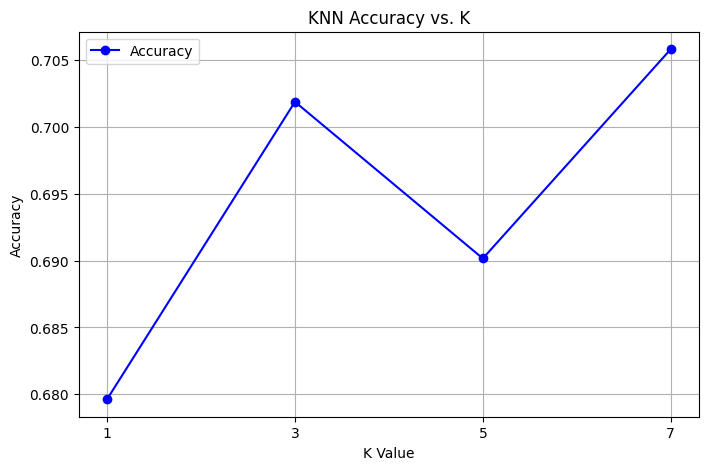

In [ ]:
# K value vs. Accuracy: draw a 2D plot to show the accuracy of KNN classifier vs different number of k’s. 
# reference: co-pilot (I used co-pilot to look for the functions to look for the steps to create the plot
# because I'm not familiar with matplot and figure the usage should be straightforward) and 
# https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib
import matplotlib.pyplot as plt

# Extract K values and corresponding accuracies
k_values = list(accuracy_results.keys())
accuracies = list(accuracy_results.values())

# Create the plot
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")

# Labels and title
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. K")
plt.xticks(k_values)
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Comment on the result and print misclassified records in table format where you show the true label in one column and the predicted 
# label in another column.
# reference: co-pilot (same reason as above --- used co-pilot to look for the steps because I was unfamiliar, and then 
# reference https://github.com/scikit-learn/scikit-learn/issues/18533)
import pandas as pd

# Create a DataFrame showing misclassified instances
misclassified = pd.DataFrame({'True Label': y_test, 'Predicted Label': predictions})

# Filter misclassified cases
misclassified_records = misclassified[misclassified['True Label'] != misclassified['Predicted Label']]

# Print the table
print(misclassified_records)

     True Label  Predicted Label
755           1                0
622           0                1
673           0                1
406           1                0
36            0                1
276           1                0
725           0                1
507           0                1
128           1                0
539           1                0
715           1                0
264           1                0
719           1                0
678           1                0
301           1                0
722           1                0
400           1                0
362           0                1
184           0                1
470           0                1
312           1                0
164           1                0
709           1                0
70            1                0
242           1                0
230           1                0
397           1                0
116           1                0
592           1                0
338       

In [48]:
# Question 2 Part 2 (Lane)
print("\nQuestion 2 Part 2: Predicting the onset of diabetes based on diagnostic measures.")
# fit a Gaussian Naive Bayes model to the training data
from sklearn.naive_bayes import GaussianNB # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
model = GaussianNB()
model.fit(X_train, y_train)



Question 2 Part 2: Predicting the onset of diabetes based on diagnostic measures.


GaussianNB()

In [49]:

# Q2P2 Accuracy
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Naive Bayes model: {accuracy:.4f}")

Accuracy of Naive Bayes model: 0.6948


In [50]:
# Q2P2 Show misclassified samples
misclassified_diabetes = X_test.copy()
misclassified_diabetes['true_outcome'] = y_test
misclassified_diabetes['predicted_outcome'] = y_pred
misclassified_diabetes = misclassified_diabetes[y_test != y_pred]
print("\nMisclassified Samples (Diabetes Prediction):")
print(misclassified_diabetes[['true_outcome', 'predicted_outcome']])


Misclassified Samples (Diabetes Prediction):
     true_outcome  predicted_outcome
44              0                  1
630             1                  0
335             0                  1
78              1                  0
392             0                  1
678             1                  0
116             1                  0
660             0                  1
260             0                  1
17              1                  0
517             0                  1
64              1                  0
153             0                  1
469             0                  1
124             1                  0
345             0                  1
745             0                  1
264             1                  0
560             1                  0
276             1                  0
535             1                  0
558             0                  1
428             0                  1
756             0                  1
419             1            